# Simulating a Quantum Random Walk

Code implementation of a Hadamard walk using Qiskit

In [5]:
import numpy as np
from qiskit import(
    QuantumCircuit,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
from matplotlib import pyplot as plt 

# Use Aer's qasm_simulator
simulator = Aer.get_backend('qasm_simulator')

## Simulation Parameters

- Set `n` to be the number of bits used to represent the state.
- Set the boolean `make_symmetric` to set whether or not we should start with the state $|0\rangle\otimes|0\rangle$ (`False`) or $\frac{1}{\sqrt{2}}\left(|0\rangle+i |1\rangle\right)\otimes |0\rangle$ (`True`). As we discuss in our report, this causes a skewed or symmetric distribution.
- Set `num_steps` to be the number of steps in the walk. If this exceeds $2^{n-1}-1$, it will be set to this value instead.

In [6]:
n = 8 # number of bits for state

# note: starts to take a while for n>5
num_qubits = n + 1 # 1 additional bit for coin flip

make_symmetric = True

num_steps = 64

## Increment and Decrement Gates

Here we define the increment and decrement translations to be used for the simulation

In [7]:
increment_circuit = QuantumCircuit(n, name='add1')
for i in range(n - 1):
    increment_circuit.mcx([j for j in range(n - 1 - i)], n - 1 - i)
increment_circuit.x(0)

increment_circuit.draw()

┌───┐
q_0: ──■────■────■────■────■────■────■──┤ X ├
       │    │    │    │    │    │  ┌─┴─┐└───┘
q_1: ──■────■────■────■────■────■──┤ X ├─────
       │    │    │    │    │  ┌─┴─┐└───┘     
q_2: ──■────■────■────■────■──┤ X ├──────────
       │    │    │    │  ┌─┴─┐└───┘          
q_3: ──■────■────■────■──┤ X ├───────────────
       │    │    │  ┌─┴─┐└───┘               
q_4: ──■────■────■──┤ X ├────────────────────
       │    │  ┌─┴─┐└───┘                    
q_5: ──■────■──┤ X ├─────────────────────────
       │  ┌─┴─┐└───┘                         
q_6: ──■──┤ X ├──────────────────────────────
     ┌─┴─┐└───┘                              
q_7: ┤ X ├───────────────────────────────────
     └───┘

In [8]:
increment_gate = increment_circuit.to_gate()
controlled_increment_gate = increment_gate.control()

In [9]:
decrement_circuit = QuantumCircuit(n, name='sub1')
decrement_circuit.x(0)
for i in range(n - 1):
    decrement_circuit.mcx([j for j in range(i+1)], i+1)

decrement_circuit.draw()

┌───┐                                   
q_0: ┤ X ├──■────■────■────■────■────■────■──
     └───┘┌─┴─┐  │    │    │    │    │    │  
q_1: ─────┤ X ├──■────■────■────■────■────■──
          └───┘┌─┴─┐  │    │    │    │    │  
q_2: ──────────┤ X ├──■────■────■────■────■──
               └───┘┌─┴─┐  │    │    │    │  
q_3: ───────────────┤ X ├──■────■────■────■──
                    └───┘┌─┴─┐  │    │    │  
q_4: ────────────────────┤ X ├──■────■────■──
                         └───┘┌─┴─┐  │    │  
q_5: ─────────────────────────┤ X ├──■────■──
                              └───┘┌─┴─┐  │  
q_6: ──────────────────────────────┤ X ├──■──
                                   └───┘┌─┴─┐
q_7: ───────────────────────────────────┤ X ├
                                        └───┘

In [10]:
decrement_circuit = decrement_circuit.to_gate()
controlled_decrement_gate = decrement_circuit.control()

## Create Circuit

This code creates the circuit for the walk specified by the parameters above. Uncomment the final line to see a visualization, though this will be large and visually confusing for large `num_steps`.

In [11]:
num_steps = min(num_steps, 2**(n-1) - 1)
# should only do at most 2^(n-1) - 1 steps (right bound for signed integer)

trials = 10000

qc = QuantumCircuit(num_qubits, n)

# first qubit is coin flip
# other qubits are state/position qubits, with one bit for sign (leftmost bit)

if make_symmetric:
    # for symmetric distribution
    qc.h(0)
    qc.s(0)

for i in range(num_steps):
    qc.h(0)
    # controlled increment
    qc.append(controlled_increment_gate, [j for j in range(num_qubits)])
    
    
    # controlled decrement
    qc.x(0)
    qc.append(controlled_decrement_gate, [j for j in range(num_qubits)])
    qc.x(0)
    
# qc.draw()

## Run Simulation

Uses the Qiskit Aer simulator to simulate the walk. Prints the probability distribution as well as generates a plot.

In [12]:
# Map the quantum measurement to the classical bits
qc.measure([i+1 for i in range(n)], [i for i in range(n)])

# Execute the circuit on the qasm simulator
job = execute(qc, simulator, shots=trials)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(qc)
print("\nTotal counts (signed binary representation):", counts)

def to_decimal(num):
    if num[0]=='0':
        return int(num, 2)
    else:
        return int(num, 2) - (1 << len(num))

distribution = {}
for x in counts:
    distribution[to_decimal(x)] = counts[x]/trials

print("\nStates and Probabilities (decimal representation):", distribution)


Total counts (signed binary representation): {'00000000': 111, '00010000': 78, '00010010': 94, '00010100': 111, '00010110': 171, '00011000': 125, '00011010': 107, '00011100': 198, '00011110': 191, '00000010': 102, '00100000': 111, '00100010': 331, '00100100': 120, '00100110': 439, '00101000': 93, '00101010': 810, '00101100': 874, '00101110': 311, '00110000': 54, '00110010': 6, '00000100': 107, '00000110': 102, '00001000': 107, '00001010': 104, '00001100': 114, '11001110': 5, '11010000': 59, '11010010': 316, '11010100': 870, '11010110': 773, '11011000': 84, '11011010': 484, '11011100': 110, '11011110': 303, '00001110': 127, '11100000': 89, '11100010': 206, '11100100': 195, '11100110': 100, '11101000': 134, '11101010': 158, '11101100': 120, '11101110': 90, '11110000': 90, '11110010': 115, '11110100': 110, '11110110': 101, '11111000': 101, '11111010': 80, '11111100': 123, '11111110': 86}

States and Probabilities (decimal representation): {0: 0.0111, 16: 0.0078, 18: 0.0094, 20: 0.0111, 2

<BarContainer object of 51 artists>

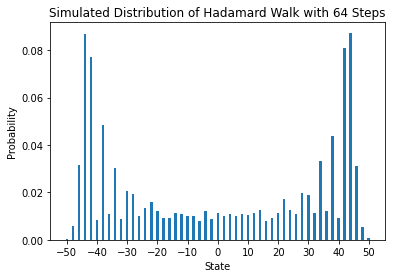

In [13]:
plt.xlabel("State")
if num_steps % 2 == 1:
    plt.xticks([10*i+1 for i in range(-(num_steps + 1)//10, (num_steps + 1)//10)])
else:
    plt.xticks([10*i for i in range(-num_steps//10, num_steps//10+1)])
plt.ylabel("Probability")
plt.title(f"Simulated Distribution of Hadamard Walk with {num_steps} Steps")
plt.bar(list(distribution.keys()), list(distribution.values()))